# Kelompok 1 Data Mining SD-A2
#### **Anggota**:
#### - Najma Attaqiya Alya (162012133015)
#### - Muhammad Hanif Sudibyo (162012133040)
#### - Razin Isyraq Thirafi (162012133056)
#### - Ergidya Liviani (162012133065)

## Dataset yang digunakan:
https://unairacid-my.sharepoint.com/:f:/g/personal/muhammad_hanif_sudibyo-2020_ftmm_drive_unair_ac_id/EhQur1UzripBgWcTK-j69A8BwQakXwH_x4bZuhBStA2qvQ?e=P4QZqn

Dataset merupakan data yang memuat gambar display dari website toko fashion terkenal seperti Louis Vuitton, Dior, Gucci, Uniqlo, dan Prada.

<div style='color: lightblue;
           background-color: black;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: dashed;
           border-color: lightblue;
           font-family: "Verdana";'>
Import Packages
<a class="anchor" id="1"></a> 

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras
from keras.utils import plot_model

import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# ML Model
from sklearn.naive_bayes import MultinomialNB

# DL Model
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

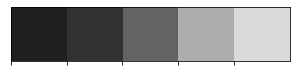

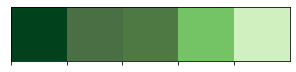

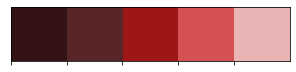

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

<div style='color: lightblue;
           background-color: black;
           font-size: 200%;
           border-radius:15px;
           text-align:center;
           font-weight:600;
           border-style: dashed;
           border-color: lightblue;
           font-family: "Verdana";'>
Import Data
<a class="anchor" id="1"></a> 

In [3]:
labels = ['Bags','Belts','Boots','Dresses','Hats','Jackets & Coats','Jewelry','Knitwear','Loafers',
 'Pants','Sandals','Scarves','Skirt','Sneakers','Sunglasses','T-Shirts']

X = []
y_train = []

image_size = 400 

# All Data
for i in labels:
    folderPath = os.path.join(r"C:\Users\Zagreus\Documents\DUMMY\Dokumen Pribadi\College\Data Mining II\12.1. Scrap Fashion\Dataset",i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        try:
            img = cv2.resize(img,(image_size,image_size))
        except:
            print(i, j)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        X.append(img)
        y_train.append(i)
print('Data train DONE!')

X = np.array(X)
y_train = np.array(y_train)

100%|██████████| 677/677 [00:11<00:00, 60.59it/s] 


Data train DONE!


# Histogram sample size

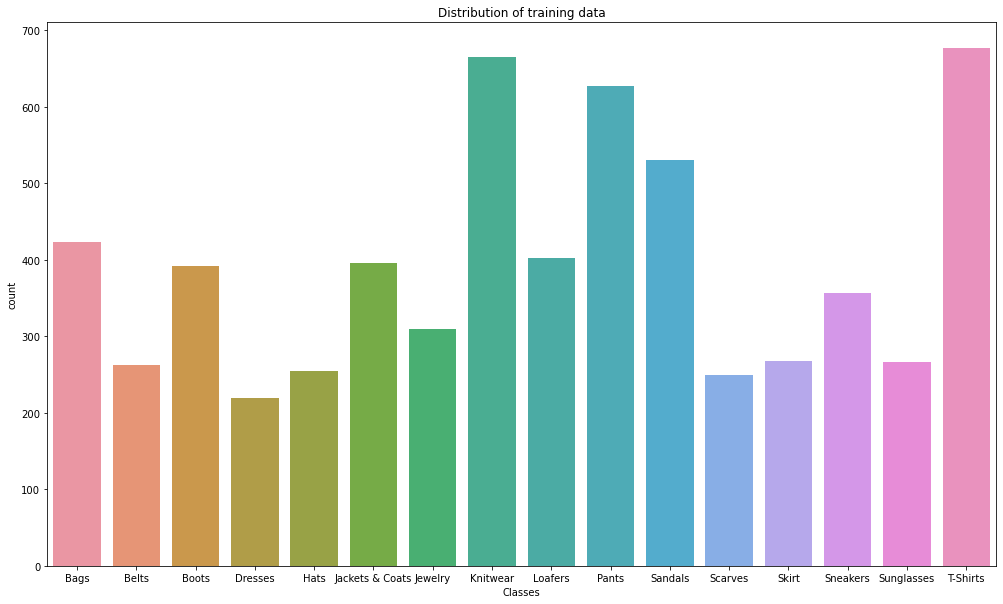

In [4]:
plt.figure(figsize=(17,10))
# Count plot for training set
sns.countplot(x = y_train.ravel())
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()

## Sample Image

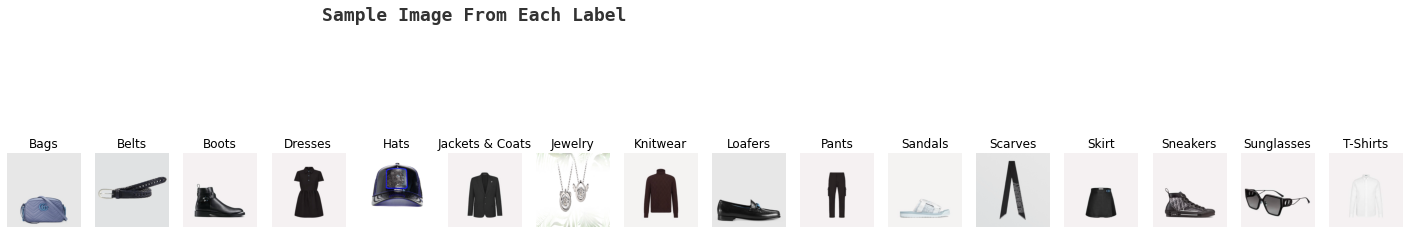

In [5]:
k=0
fig, ax = plt.subplots(1,len(labels),figsize=(25,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.3,alpha=0.8)
for i in labels:
    f=1
    while True :
        if y_train[f]==i:
            ax[k].imshow(X[f])
            ax[k].set_title(y_train[f])
            ax[k].axis('off')
            k+=1
            break
        f+=1

# Preprocessing

## Split Data

In [6]:
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(X, y_train, train_size=0.8, random_state=42)

In [7]:
X_train = x_train.astype('float32') #set x_train data type as float32
X_test = x_test.astype('float32') #set x_test data type as float32
X_train /= 255 #change x_train value between 0 - 1
X_test /= 255 #change x_test value between 0 - 1

In [8]:
encoder = OrdinalEncoder()

y_train_ml = encoder.fit_transform(y_train.reshape(-1,1))
y_test_ml = encoder.fit_transform(y_test.reshape(-1,1))

In [9]:
print(len(X_train))
print(len(X_test))

5043
1261


In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new.copy()
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new.copy()
y_test = tf.keras.utils.to_categorical(y_test)

## Data Augmenting

In [11]:
batch_size=16

train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator()
validation_datagen.fit(X_test)
validation_generator = validation_datagen.flow(
    X_test,
    y_test
)

# Modeling

## Machine Learning

In [63]:
x_train_ml = x_train.reshape(x_train.shape[0], -1)
x_test_ml = x_test.reshape(x_test.shape[0], -1)
# x_train_ml = x_train.flatten()
# x_test_ml = x_test.flatten()

In [64]:
MNB = MultinomialNB()
MNB.fit(x_train_ml, y_train_ml)
predictions = MNB.predict(x_test_ml)
print(classification_report(y_test_ml, predictions, digits=6))

c:\Users\Zagreus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0   0.673684  0.609524  0.640000       105
         1.0   0.171053  0.619048  0.268041        42
         2.0   0.700000  0.608696  0.651163        23
         3.0   0.195122  0.363636  0.253968        44
         4.0   0.250000  0.120000  0.162162        25
         5.0   0.277027  0.554054  0.369369        74
         6.0   0.253333  0.926829  0.397906        41
         7.0   0.500000  0.151786  0.232877       112
         8.0   0.392857  0.354839  0.372881        31
         9.0   0.600000  0.295082  0.395604       122
        10.0   0.285714  0.166667  0.210526        24
        11.0   0.194444  0.368421  0.254545        19
        12.0   0.217391  0.333333  0.263158        45
        13.0   0.166667  0.013699  0.025316        73
        14.0   0.685714  0.489796  0.571429        49
        15.0   0.391304  0.066667  0.113924       135

    accuracy                       0.338174       964
   macro avg   0.372144  0

## Deep Learning

### Definisi Model

In [12]:
input_shape = (400,400,3)

# load base model
inception = InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)

### Arsitektur Model

In [13]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

inceptionv3 = Sequential()
inceptionv3.add(inception)
inceptionv3.add(Flatten())
#Fully-connected
inceptionv3.add(Dense(256, activation = 'relu'))
inceptionv3.add(BatchNormalization())
inceptionv3.add(Dropout(0.1))
#output mengguunakan softmax
inceptionv3.add(Dense(16, activation='softmax'))

In [14]:
plot_model(inception, show_shapes=True, show_layer_names=True)

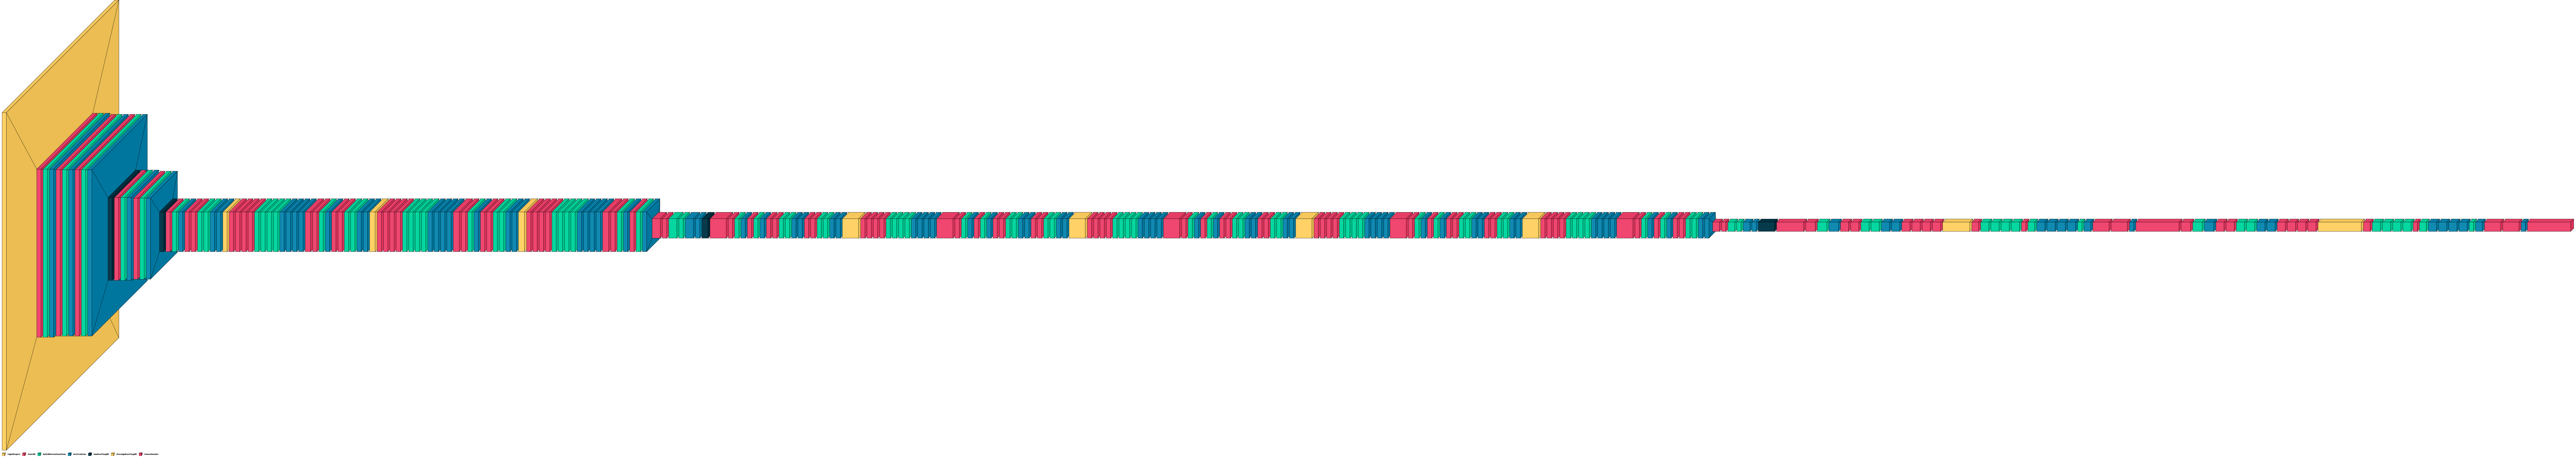

In [15]:
visualkeras.layered_view(inception, legend=True)

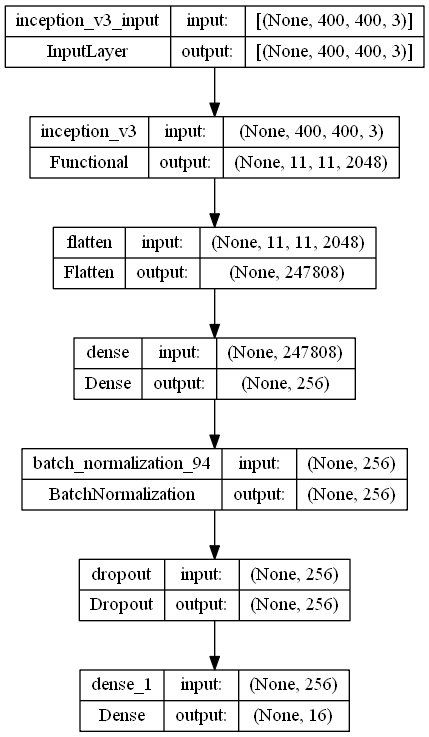

In [16]:
plot_model(inceptionv3, show_shapes=True, show_layer_names=True)

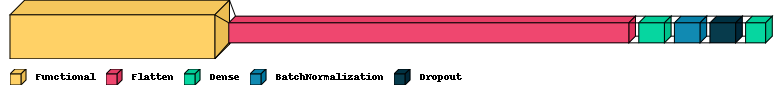

In [17]:
visualkeras.layered_view(inceptionv3, legend=True)

### Parameter Model

In [18]:
# Learning Rate
initial_learning_rate = 1e-4 # 1 x 10^-4

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2000,
    decay_rate=0.85,
    staircase=True)

METRICS = ['accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

inceptionv3.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),  # Very slow learning rate 
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics='categorical_accuracy')

### Training Model

In [19]:
# simple early stopping
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=25)
mc = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

In [20]:
tf.debugging.set_log_device_placement(True)

epochs_model = 200

inception_history = inceptionv3.fit(train_generator, 
          validation_data=(validation_generator), 
          epochs=epochs_model, 
          batch_size=12,
          callbacks=[es, mc]) 
          
# scores = inceptionv3.evaluate(X_test, y_test, verbose=0)

# print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/200
316/316 [==============================] - ETA: 0s - loss: 0.8011 - categorical_accuracy: 0.7513
Epoch 1: val_categorical_accuracy improved from -inf to 0.88025, saving model to best_model NEW YEAH FFF.h5
316/316 [==============================] - 192s 566ms/step - loss: 0.8011 - categorical_accuracy: 0.7513 - val_loss: 0.3851 - val_categorical_accuracy: 0.8803
Epoch 2/200
316/316 [==============================] - ETA: 0s - loss: 0.4633 - categorical_accuracy: 0.8505
Epoch 2: val_categorical_accuracy improved from 0.88025 to 0.88977, saving model to best_model NEW YEAH FFF.h5
316/316 [==============================] - 161s 510ms/step - loss: 0.4633 - categorical_accuracy: 0.8505 - val_loss: 0.3402 - val_categorical_accuracy: 0.8898
Epoch 3/200
316/316 [==============================] - ETA: 0s - loss: 0.3968 - categorical_accuracy: 0.8650
Epoch 3: val_categorical_accuracy improved from 0.88977 to 0.89849, saving model to best_model NEW YEAH FFF.h5
316/316 [================

# Evaluasi Model

C:\Users\Zagreus\AppData\Local\Temp\ipykernel_3024\1323563479.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


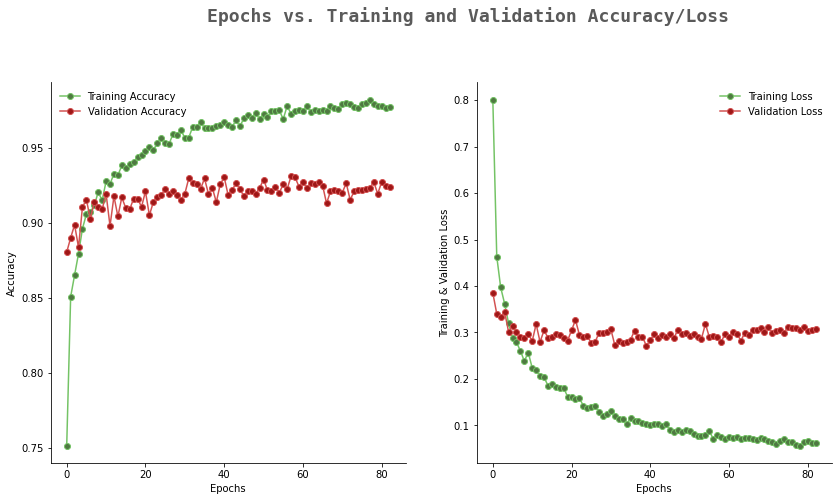

In [22]:
epochs = [i for i in range(83)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = inception_history.history['categorical_accuracy']
train_loss = inception_history.history['loss']
val_acc = inception_history.history['val_categorical_accuracy']
val_loss = inception_history.history['val_loss']

#menampilkan judul
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', 
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8) 

#membuat kurva
sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [23]:
pred = inceptionv3.predict(X_test)
pred = np.argmax(pred,axis=1)

print(classification_report(y_test_new,pred,target_names=labels, digits=6))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [24]:
y_hat = inceptionv3.predict(X_test)
# Plot a random sample of 54 test images, their predicted labels and ground truth
figure = plt.figure(figsize= (25, 40))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=70, replace=False)): # size (jumlah total data uji)
    ax = figure.add_subplot(20, 4, i + 1, xticks=[], yticks=[]) #ukuran 10 X 7 untuk visualisasi gambar pada heatmap confusion matrix
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.